In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, GlobalAveragePooling1D,GlobalMaxPooling1D,MaxPooling1D,Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import re

In [28]:
data = pd.read_csv('/content/Reviews.csv',engine="python",quotechar='"')

In [29]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [30]:
data["sentiment"]=data["Score"].apply(lambda x:1 if x>=4 else 0)

In [31]:
def clean_text(text):
  text=str(text).lower()
  text=re.sub(r'[^a-zA-Z\s]','',text)
  text=re.sub(r'\s+'," ",text).strip()
  return text

data["cleaned_text"]=data["Text"].apply(clean_text)

In [32]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment,cleaned_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,i have bought several of the vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,product arrived labeled as jumbo salted peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,this is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,if you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,great taffy at a great price there was a wide ...


In [33]:
X=data["cleaned_text"]
y=data["sentiment"]

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [48]:
# Токенезируем данные
vocab_size = 10000  # Указываем размер нашего словаря
max_length = 80    # Максимальное количество токенов в предложении
trunc_type = 'post' # Удаляем части предложений, которые идут после лимита
padding_type = 'post' # Добавляем текст в конец предложений что бы достич лимита
oov_tok = '<OOV>'   # Заменям слова, которых нет в словаре данным токеном

tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X)

In [49]:
# Токенезируем текст
train_seq=tokenizer.texts_to_sequences(X_train)
test_seq=tokenizer.texts_to_sequences(X_test)
# Добиваем размер предложений до нашего лимита
train_seq=pad_sequences(train_seq,maxlen=max_length, padding=padding_type, truncating=trabc_type)
test_seq=pad_sequences(test_seq,maxlen=max_length, padding=padding_type, truncating=trabc_type)

In [55]:
train_seq[200]

array([  10,   43,    9,   40,    7,    9,    5,  141, 3805,   15,   37,
         19,  151,   17,  116,    4,  153,   63, 2621,   25,    5,  664,
         10,    9,    2,   43,    6,   85,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [74]:
model=Sequential([
    Embedding(input_dim=vocab_size,output_dim=100,input_length=max_length),
    Conv1D(filters=128,kernel_size=5,padding="valid",activation="relu"),
    MaxPooling1D(pool_size=4),
    Dense(64,activation="relu"),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(1,activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [75]:
early_estopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [76]:
history=model.fit(
    train_seq,y_train,
    epochs=20,
    batch_size=32,
    validation_data=(test_seq,y_test),
    callbacks=[early_estopping],
    verbose=1
)

Epoch 1/20
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 576s 40ms/step - accuracy: 0.8761 - loss: 0.2925 - precision_4: 0.8970 - recall_3: 0.9517 - val_accuracy: 0.9146 - val_loss: 0.2472 - val_precision_4: 0.9334 - val_recall_3: 0.9594
Epoch 2/20
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 609s 39ms/step - accuracy: 0.9278 - loss: 0.1870 - precision_4: 0.9449 - recall_3: 0.9637 - val_accuracy: 0.9208 - val_loss: 0.2217 - val_precision_4: 0.9398 - val_recall_3: 0.9604
Epoch 3/20
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 559s 39ms/step - accuracy: 0.9455 - loss: 0.1449 - precision_4: 0.9591 - recall_3: 0.9717 - val_accuracy: 0.9228 - val_loss: 0.2016 - val_precision_4: 0.9319 - val_recall_3: 0.9726
Epoch 4/20
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 597s 42ms/step - accuracy: 0.9599 - loss: 0.1108 - precision_4: 0.9704 - recall_3: 0.9784 - val_accuracy: 0.9239 - val_loss: 0.2045 - val_precision_4: 0.9444 - val_recall_3: 0.9593
Epoch 5/20
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 563s 40ms/step - accuracy: 0.9706 - loss: 0.0826 - preci

In [78]:
# Оцениваем тестовые данные
loss, accuracy, precision, recall = model.evaluate(test_seq, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Делаем предсказания
y_pred = (model.predict(test_seq) > 0.5).astype("int32")


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.9222 - loss: 0.2032 - precision_4: 0.9303 - recall_3: 0.9735
Test Accuracy: 0.9228
Test Precision: 0.9319
Test Recall: 0.9726
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.74      0.81     24666
    Positive       0.93      0.97      0.95     89025

    accuracy                           0.92    113691
   macro avg       0.91      0.86      0.88    113691
weighted avg       0.92      0.92      0.92    113691


Confusion Matrix:
[[18335  6331]
 [ 2441 86584]]


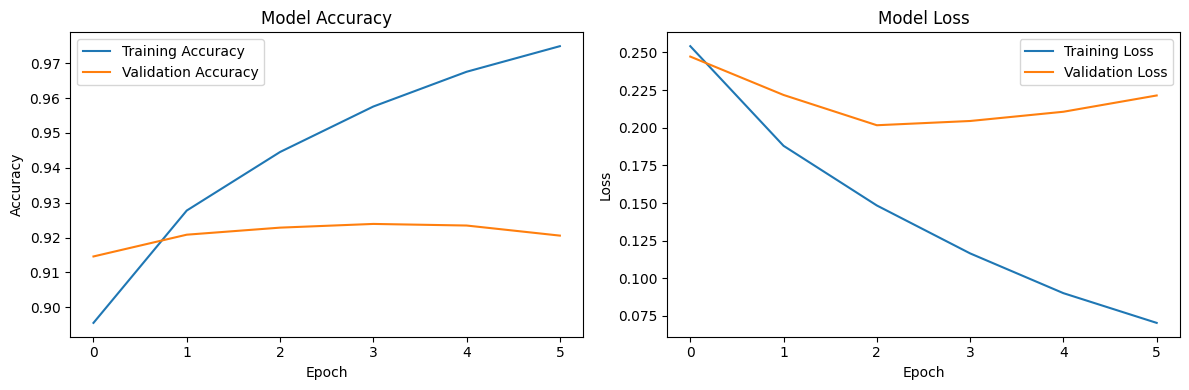

In [79]:
# Строим график обучения
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)